In [55]:
%%markdown
# Implementation of LSTM for the nowcasting data

# Implementation of LSTM for the nowcasting data

In [56]:
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy
#from sklearn.model_selection import train_test_split

In [57]:
series = pd.read_csv("nowacst.csv")

In [58]:
series.head()

,0,14
0,1,63
1,2,6
2,3,139
3,4,7
4,5,29


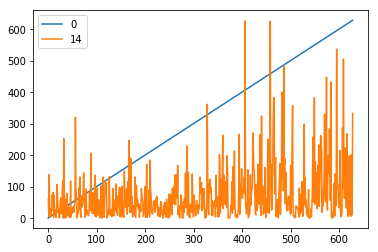

In [59]:
series.plot()

In [60]:
series.shape

(629, 2)

In [61]:
X = series.values

In [62]:
X

array([[  1,  63],
       [  2,   6],
       [  3, 139],
       ...,
       [627,   9],
       [628,  20],
       [629, 333]], dtype=int64)

In [63]:
#print(train)

In [64]:
%%markdown
# Converting data into supervised form

For LSTM we need data in a supervised format. So we shift the input series one step forward in time and thus the new series will become output. 

# Converting data into supervised form

For LSTM we need data in a supervised format. So we shift the input series one step forward in time and thus the new series will become output. 

In [65]:
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [66]:
supervised = timeseries_to_supervised(X, 1)

In [67]:
supervised.head()

,0,1,0,1
0,0.0,0.0,1,63
1,1.0,63.0,2,6
2,2.0,6.0,3,139
3,3.0,139.0,4,7
4,4.0,7.0,5,29


In [68]:
%%markdown
It is pretty evident from the series plot as well as the general understanding of the earthquakes that the series is stationary. So we can directly proceed without converting it into stationary.

It is pretty evident from the series plot as well as the general understanding of the earthquakes that the series is stationary. So we can directly proceed without converting it into stationary.

In [69]:
%%markdown
# Transform Time Series to Scale

# Transform Time Series to Scale

In [70]:
%%markdown
Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

Like other neural networks, LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.

In [71]:
def scale(train, test):
    #fit scaler
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    #transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    #transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


In [72]:
# inverse scaling for forecasted value

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [73]:
%%markdown
# Fit an LSTM network to training data

# Fit an LSTM network to training data

In [74]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape = (batch_size, X.shape[1], 
                                                X.shape[2]), stateful = True))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs = 1, batch_size = batch_size, 
                 shuffle = False)
        model.reset_states()
    return model    

In [75]:
%%markdown
# Make a one-step forecast

# Make a one-step forecast

In [76]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size = batch_size)
    return yhat[0, 0]

In [77]:
# Scale the data

scaler, train_scaled, test_scaled = scale(train, test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [83]:
# fit the model

lstm_model = fit_lstm(train_scaled, 1, 1000, 1)

In [84]:
# forecast the  entire training daatset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size = 1)

array([[-0.79131377],
       [-0.84125626],
       [-0.8486285 ],
       [-0.8496802 ],
       [-0.84982073],
       [-0.8498268 ],
       [-0.8498125 ],
       [-0.8497949 ],
       [-0.84977686],
       [-0.8497587 ],
       [-0.8497405 ],
       [-0.84972227],
       [-0.8497041 ],
       [-0.8496859 ],
       [-0.84966767],
       [-0.8496495 ],
       [-0.8496313 ],
       [-0.84961313],
       [-0.84959495],
       [-0.8495767 ],
       [-0.84955853],
       [-0.84954035],
       [-0.8495221 ],
       [-0.84950393],
       [-0.84948575],
       [-0.8494675 ],
       [-0.84944934],
       [-0.84943116],
       [-0.8494129 ],
       [-0.84939474],
       [-0.84937656],
       [-0.8493583 ],
       [-0.84934014],
       [-0.84932196],
       [-0.8493037 ],
       [-0.8492856 ],
       [-0.84926736],
       [-0.8492492 ],
       [-0.849231  ],
       [-0.84921277],
       [-0.8491946 ],
       [-0.8491764 ],
       [-0.84915817],
       [-0.84914   ],
       [-0.8491218 ],
       [-0

In [ ]:
#walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    
    # make one-step forecast